# One of My Most Favorite Teaching Data Sets:
## Global Historical Climatology Network (GHCN)

* Understandable Variables:
    * PRCP = Precipitation (tenths of mm)
    * SNOW = Snowfall (mm)
	* SNWD = Snow depth (mm)
    * TMAX = Maximum temperature (tenths of degrees C)
    * TMIN = Minimum temperature (tenths of degrees C)
    * TAVG = Average temperature (tenths of degrees C)
* Plus more: https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt
* Scales well:
    * records from over 100,000 stations in 180 countries and territories
    * data back to 1763, available in daily, monthly, and annual 
* Widely available in some form of CSV & fairly clean

In [42]:
from ftplib import FTP
from pathlib import Path

import pandas as pd
import geopandas as gpd
from tqdm.notebook import trange, tqdm

import dask.bag as db
import dask.dataframe as dd
import dask.diagnostics as dg

import metpy

In [41]:
%conda install ipympl

Solving environment: \ 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - conda-forge/noarch::pyspectral==0.9.4=py_0
  - conda-forge/noarch::ioos-tools==1.4.0=py_0
  - conda-forge/noarch::xskillscore==0.0.11=py_0
  - conda-forge/noarch::intake-stac==0.2.2=py_0
  - conda-forge/noarch::xrft==0.2.0=py_0
  - conda-forge/noarch::climpred==1.1.0=py_1
  - conda-forge/noarch::prefect==0.7.3=py_0
  - conda-forge/noarch::xhistogram==0.1.1=py_0
  - conda-forge/noarch::datashader==0.9.0=py_0
  - conda-forge/noarch::dask-glm==0.2.0=py_1
  - conda-forge/noarch::intake-xarray==0.3.1=py_0
  - conda-forge/noarch::s3fs==0.4.0=py_0
  - conda-forge/noarch::intake==0.5.3=py_0
  - conda-forge/noarch::xrviz==0.1.4=py_1
  - conda-forge/noarch::trollimage==1.11.0=py_0
  - conda-forge/noarch::geoviews==1.6.6=py_0
  - conda-forge/linux-64::iris==2.2.0=py37_1003
  - conda-forge/noarch::dask-ml==1.1.1=py_0
  - conda-forge/noarch::sat

In [43]:
!jupyter labextension install jupyter-matplotlib

Building jupyterlab assets (build:prod:minimize)


In [ ]:
import matplotlib.pyplot
%matplotlib widget

# Download GHCN Daily & the Station List (approx 10 minutes)

In [5]:
GHCNP = Path('ghcn_files')
GHCNP.mkdir(parents=True, exist_ok=True)
station_file = GHCNP.joinpath('ghcnd-stations.txt')

In [6]:
with FTP("ftp.ncdc.noaa.gov") as ftp:
    ftp.login()
    
    ftp.cwd('pub/data/ghcn/daily/')
    
    with open(station_file, 'wb') as stations:
        ftp.retrbinary(f'RETR {station_file.name}', stations.write) 
    ftp.cwd("by_year/")
    files = ftp.nlst()
    print(f'{len(files)} files')
    
    for filename in tqdm(files):
        fpath = Path(GHCNP.joinpath(filename))
        if not fpath.exists():
            with open(fpath, 'wb') as myfile:
                ftp.retrbinary('RETR '+ filename, myfile.write)
                

261 files


In [7]:
columns = {"ID": (0,11),
           "LATITUDE": (12, 20), 
           "LONGITUDE": (21, 30),
           "ELEVATION": (31, 37),
           "STATE": (38, 40),
           "NAME": (41, 71),
           "GSN FLAG": (72, 75),
           "HCN/CRN FLAG": (76, 79),
           "WMO ID": (80, 85)}

In [8]:
def parse_row(line):
    return dict([(col, line[start:stop]) for col, (start, stop) in columns.items()])

with dg.ProgressBar():
    with open(station_file) as f:
        lines = f.readlines()
    rows = db.from_sequence(lines).map(parse_row).compute()

[########################################] | 100% Completed |  2.0s


In [9]:
rows[0]

{'ID': 'ACW00011604',
 'LATITUDE': ' 17.1167',
 'LONGITUDE': ' -61.7833',
 'ELEVATION': '  10.1',
 'STATE': '  ',
 'NAME': 'ST JOHNS COOLIDGE FLD         ',
 'GSN FLAG': '   ',
 'HCN/CRN FLAG': '   ',
 'WMO ID': '     '}

In [10]:
dfst = pd.DataFrame(rows)
dfst.head()

,ID,LATITUDE,LONGITUDE,ELEVATION,STATE,NAME,GSN FLAG,HCN/CRN FLAG,WMO ID
0,ACW00011604,17.1167,-61.7833,10.1,,ST JOHNS COOLIDGE FLD,,,
1,ACW00011647,17.1333,-61.7833,19.2,,ST JOHNS,,,
2,AE000041196,25.3330,55.5170,34.0,,SHARJAH INTER. AIRP,GSN,,41196
3,AEM00041194,25.2550,55.3640,10.4,,DUBAI INTL,,,41194
4,AEM00041217,24.4330,54.6510,26.8,,ABU DHABI INTL,,,41217


* ID = 11 character station identification code
* YEAR/MONTH/DAY = 8 character date in YYYYMMDD format (e.g. 19860529 = May 29, 1986)
* ELEMENT = 4 character indicator of element type 
* DATA VALUE = 5 character data value for ELEMENT 
* M-FLAG = 1 character Measurement Flag 
* Q-FLAG = 1 character Quality Flag 
* S-FLAG = 1 character Source Flag 
* OBS-TIME = 4-character time of observation in hour-minute format (i.e. 0700 =7:00 am)

## Filter down to CONUS

In [11]:
usa_st = dfst[~(dfst['STATE'].str.match(' ') & dfst['STATE'].isin(['AK', 'HI']))]

# Load up and filter down the GHCN
## Lets grab CONUS Temperature data 

In [13]:
names = ['ID', 'DATE', 'ELEMENT', 'DATA_VALUE', 'M-FLAG', 'Q-FLAG', 'S-FLAG', 'OBS-TIME']

In [14]:
!du -h -d  1 ghcn_files

16G	ghcn_files


In [24]:
!gunzip ghcn_files/2019.csv.gz

In [25]:
!du -h -d 1 ghcn_files/2019.csv

1.1G	ghcn_files/2019.csv


## For the sake of ease, we'll only grab the last 20 years

In [28]:
#r pandas is better behaved for the 
df = pd.read_csv(GHCNP.joinpath("2019.csv"), names=names, memory_map=False, 
                    dtype={'M-FLAG': 'object'}, parse_dates=['DATE'])
df

,ID,DATE,ELEMENT,DATA_VALUE,M-FLAG,Q-FLAG,S-FLAG,OBS-TIME
0,US1FLSL0019,2019-01-01,PRCP,0,NaN,NaN,N,NaN
1,US1FLSL0019,2019-01-01,SNOW,0,NaN,NaN,N,NaN
2,US1NVNY0012,2019-01-01,PRCP,0,NaN,NaN,N,NaN
3,US1NVNY0012,2019-01-01,SNOW,0,NaN,NaN,N,NaN
4,US1ILWM0012,2019-01-01,PRCP,163,NaN,NaN,N,NaN
...,...,...,...,...,...,...,...,...
33225458,USR0000ABAN,2019-12-31,TMIN,6,H,NaN,U,NaN
33225459,USR0000ABAN,2019-12-31,TAVG,54,NaN,NaN,U,NaN
33225460,USC00111083,2019-12-31,PRCP,0,NaN,NaN,H,700.0
33225461,USC00111083,2019-12-31,SNOW,0,NaN,NaN,H,NaN


# Chain filtering with dask


## Only take stations that are in CONUS &
## & only temperture data

In [35]:
df[df['ID'].isin(usa_st[])].head()

,ID,DATE,ELEMENT,DATA_VALUE,M-FLAG,Q-FLAG,S-FLAG,OBS-TIME


In [36]:
dfusa = df[df['ID'].isin(usa_st['ID'].unique()) & df['ELEMENT'].isin(['TMIN', 'TMAX', 'TAVG'])]

In [37]:
dfusa.head()

,ID,DATE,ELEMENT,DATA_VALUE,M-FLAG,Q-FLAG,S-FLAG,OBS-TIME
5,USC00141761,2019-01-01,TMAX,-11,NaN,NaN,7,700.0
6,USC00141761,2019-01-01,TMIN,-139,NaN,NaN,7,700.0
12,USS0018D08S,2019-01-01,TMAX,-8,NaN,NaN,T,NaN
13,USS0018D08S,2019-01-01,TMIN,-112,NaN,NaN,T,NaN
17,USS0018D08S,2019-01-01,TAVG,-56,NaN,NaN,T,NaN


## Merge against stations to geocode

In [38]:
dfm = dfusa.merge(usa_st, how='inner', on='ID')

# What if we'd used dask to visualize our computation graph
## Good First Issue: Update Dask docs w/ full graphviz options

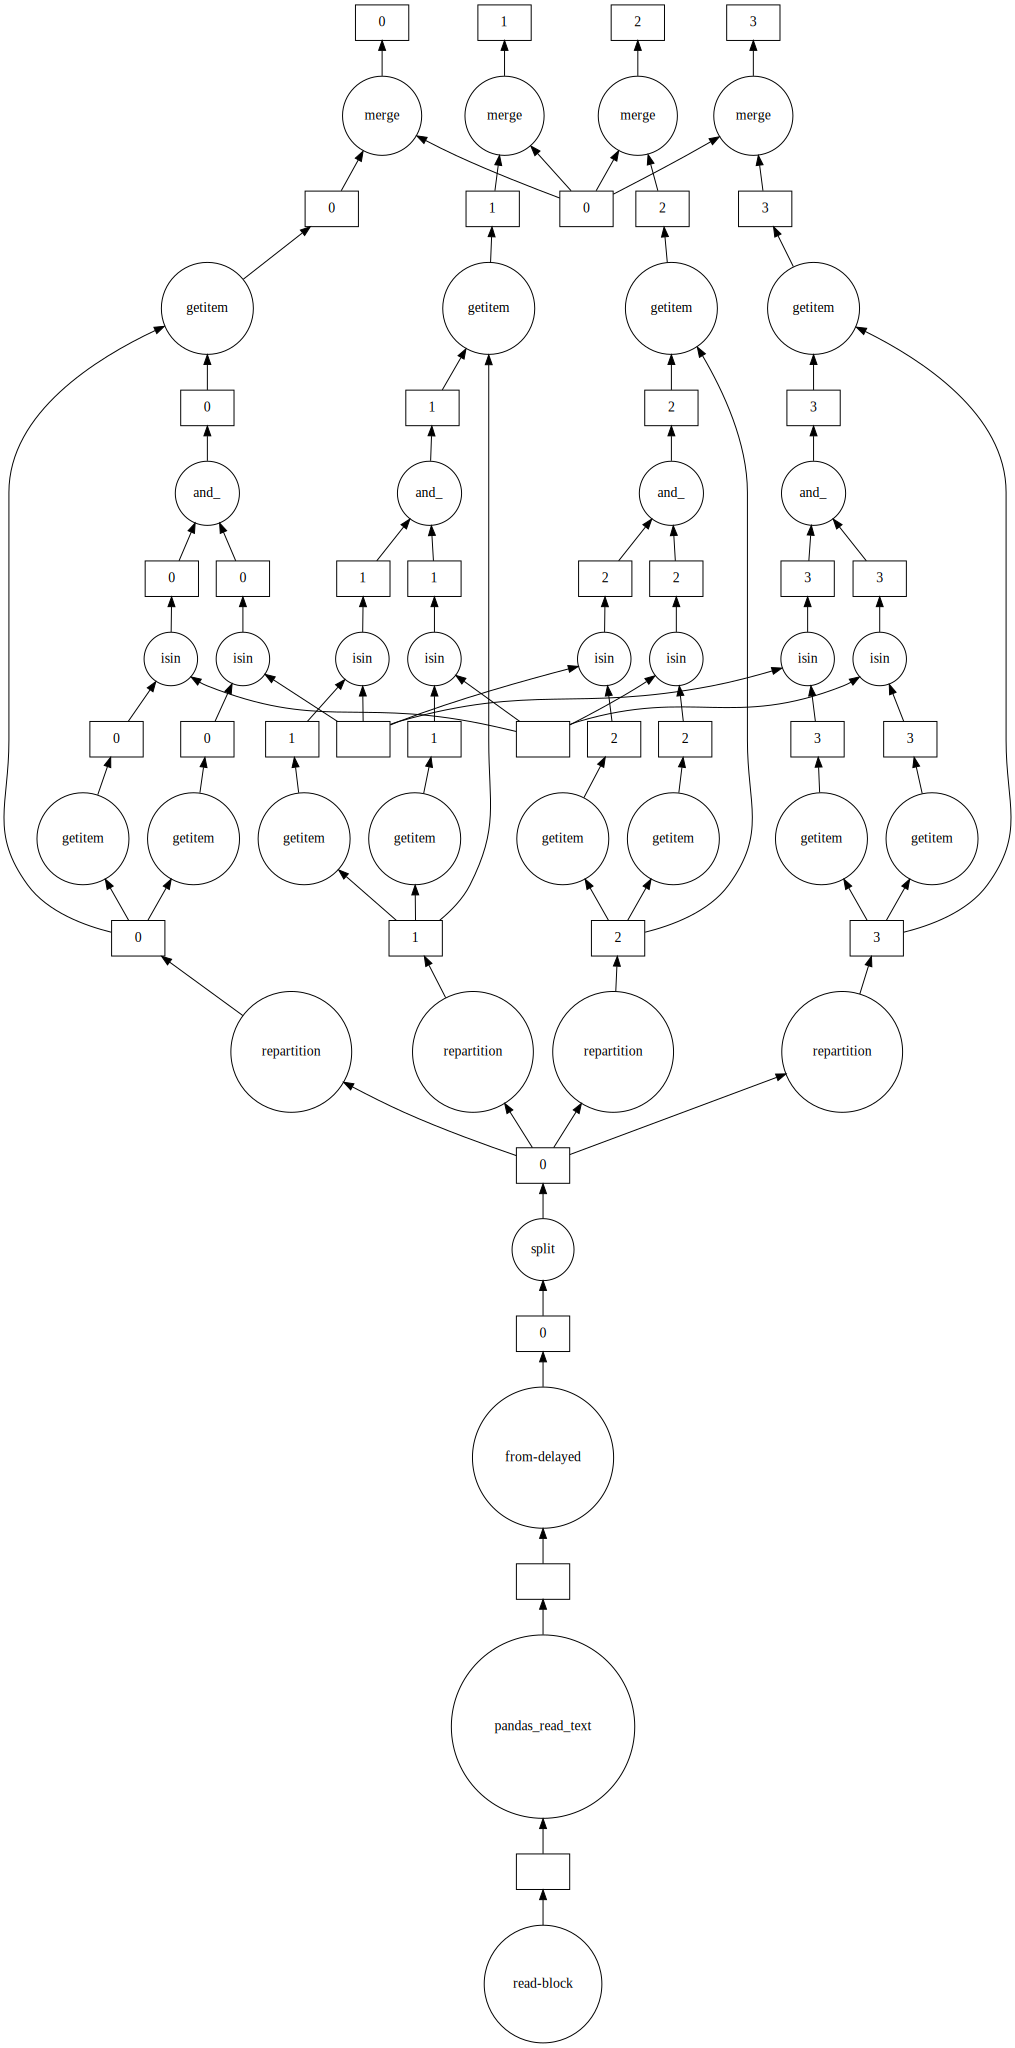

In [20]:
dfm.visualize("ghcn.svg")

In [45]:
dfm.head()

,ID,DATE,ELEMENT,DATA_VALUE,M-FLAG,Q-FLAG,S-FLAG,OBS-TIME,LATITUDE,LONGITUDE,ELEVATION,STATE,NAME,GSN FLAG,HCN/CRN FLAG,WMO ID
0,USC00141761,2019-01-01,TMAX,-11,NaN,NaN,7,700.0,39.5592,-97.6697,451.4,KS,CONCORDIA 1 W,,,
1,USC00141761,2019-01-01,TMIN,-139,NaN,NaN,7,700.0,39.5592,-97.6697,451.4,KS,CONCORDIA 1 W,,,
2,USC00141761,2019-01-02,TMAX,-78,NaN,NaN,7,700.0,39.5592,-97.6697,451.4,KS,CONCORDIA 1 W,,,
3,USC00141761,2019-01-02,TMIN,-139,NaN,NaN,7,700.0,39.5592,-97.6697,451.4,KS,CONCORDIA 1 W,,,
4,USC00141761,2019-01-03,TMAX,28,NaN,NaN,7,700.0,39.5592,-97.6697,451.4,KS,CONCORDIA 1 W,,,


In [54]:
# dfg.pivot(index='Station', columns='Observation Type', values='Observation')
dfp = dfm.head().pivot_table(index=['ID', 'DATE', 'LATITUDE', 'LONGITUDE', 'STATE', 'NAME'], columns='ELEMENT', values='DATA_VALUE').reset_index()
dfp.head()

ELEMENT,ID,DATE,LATITUDE,LONGITUDE,STATE,NAME,TMAX,TMIN
0,USC00141761,2019-01-01,39.5592,-97.6697,KS,CONCORDIA 1 W,-11.0,-139.0
1,USC00141761,2019-01-02,39.5592,-97.6697,KS,CONCORDIA 1 W,-78.0,-139.0
2,USC00141761,2019-01-03,39.5592,-97.6697,KS,CONCORDIA 1 W,28.0,NaN


In [55]:
dfp.to_csv("geocoded_ghcn_2019.csv", index=False)

In [51]:
pwd

'/home/jovyan/amspangeo'